In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import GridTransferTools as GTT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000)

This cell initializes some example AMR grid.

In [2]:
cells = [[0, 1, 3]] # , [0, 1, 6, 7]] # [[1], [2], [4, 5], [8, 9, 11]] #, [16, 17, 19, 22]]
omega = BT.Grid(4)
for i in cells:
    omega.AddCell(2, i)

This cell computes the node-centered and cell-centered modes of the `omega` grid object and then plots them.

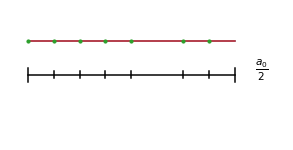

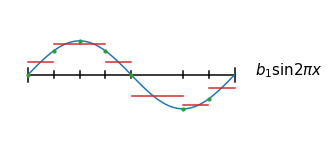

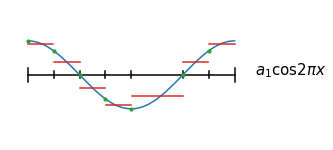

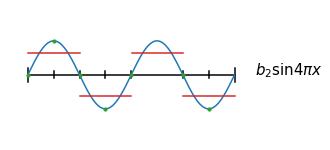

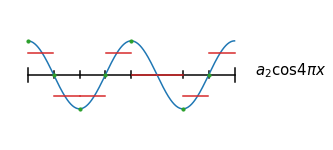

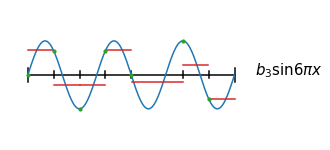

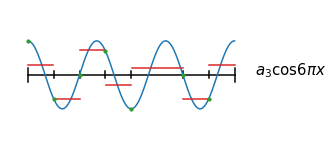

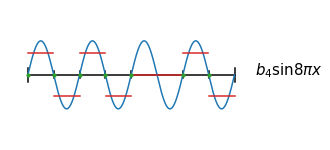

In [3]:
waves = WT.MakeWaves(omega)
wavesNode = WT.MakeNodeWaves(omega)
PT.PlotWaves(omega, waves, waveNode = wavesNode)

To go from fine to coarse, the term would be averaging down. For example, it would 0.5:0.5 for a refinement ratio of 2. This is exact for finite-volume.

To go from coarse to fine, there are two options. Piecewise constant, and piecewise linear. The piecewise linear takes neighboring values to interpolate to fine cell averages. advection

In [4]:
print(omega.refRatios)

[4, 2]


In [5]:
print(np.shape(2))
print(np.shape((2, 0)))

()
(2,)


In [6]:
print(np.any(np.asarray([1, 2]) <= 0))

False


In [7]:
a = [3, 4]
full = [0, 1, 2, 3 ,4 ,5, 6, 7]
print(full)
coarseGrid = list([int(i in a) for i in full])
mixedGrid = list(it.chain(*[(int(i in a) + 1) * [int(i in a)] for i in full]))
fineGrid = list(it.chain(*[2 * [int(i in a)] for i in full]))
print(coarseGrid)
print(mixedGrid)
print(fineGrid)

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


In [8]:
print(waves)
print('')
print(waves[:,[0,1,2,3,4,7]])

[[ 1.00000000e+00  3.72923229e-01  9.00316316e-01  6.36619772e-01  6.36619772e-01  7.24518620e-01  3.00105439e-01  6.36619772e-01]
 [ 1.00000000e+00  9.00316316e-01  3.72923229e-01  6.36619772e-01 -6.36619772e-01 -3.00105439e-01 -7.24518620e-01 -6.36619772e-01]
 [ 1.00000000e+00  9.00316316e-01 -3.72923229e-01 -6.36619772e-01 -6.36619772e-01 -3.00105439e-01  7.24518620e-01  6.36619772e-01]
 [ 1.00000000e+00  3.72923229e-01 -9.00316316e-01 -6.36619772e-01  6.36619772e-01  7.24518620e-01 -3.00105439e-01 -6.36619772e-01]
 [ 1.00000000e+00 -6.36619772e-01 -6.36619772e-01  6.36619772e-01  1.94908592e-16 -2.12206591e-01  2.12206591e-01  0.00000000e+00]
 [ 1.00000000e+00 -9.00316316e-01  3.72923229e-01 -6.36619772e-01 -6.36619772e-01  3.00105439e-01 -7.24518620e-01  6.36619772e-01]
 [ 1.00000000e+00 -3.72923229e-01  9.00316316e-01 -6.36619772e-01  6.36619772e-01 -7.24518620e-01  3.00105439e-01 -6.36619772e-01]]

[[ 1.00000000e+00  3.72923229e-01  9.00316316e-01  6.36619772e-01  6.36619772e-01

In [9]:
print(waves)
print('Before')
nh = omega.nh_max
refRatio = omega.refRatio
degFreed = omega.degFreed
smoothNum = int(nh / refRatio)
smoothWaves = waves[:, smoothNum:nh]
print(smoothWaves)
print('After')
spots = np.where(omega.h == np.min(omega.h))[0]
smoothWaves = np.delete(smoothWaves, spots, 0)
smoothWaves = np.round(smoothWaves, 15)
print(smoothWaves)
print('')
nullspace = np.round(LA2.null_space(smoothWaves), 15)
print(nullspace)
nullspace[0, :] = 0
nullspace[-1::][0, :] = 0
print('')
print(nullspace)
print('')
nullspace = np.roll(np.asarray(sympy.Matrix(nullspace.transpose()).rref()[0].transpose()), 1)
print(nullspace)
nullspace[0, 0] = 1
nullspace[-1::][0][-1::][0] = 1
print('')
print(nullspace)
fixWaves = np.zeros((nh, degFreed), float)
fixWaves[0:smoothNum, 0:smoothNum] = np.eye(smoothNum, smoothNum)
if (degFreed == smoothNum + 1):
    fixWaves[smoothNum:nh, degFreed - 1] = nullspace[:, 0]
else:
    fixWaves[smoothNum:nh, smoothNum:degFreed] = nullspace
print(fixWaves)
print('')
print(waves @ fixWaves)

[[ 1.00000000e+00  3.72923229e-01  9.00316316e-01  6.36619772e-01  6.36619772e-01  7.24518620e-01  3.00105439e-01  6.36619772e-01]
 [ 1.00000000e+00  9.00316316e-01  3.72923229e-01  6.36619772e-01 -6.36619772e-01 -3.00105439e-01 -7.24518620e-01 -6.36619772e-01]
 [ 1.00000000e+00  9.00316316e-01 -3.72923229e-01 -6.36619772e-01 -6.36619772e-01 -3.00105439e-01  7.24518620e-01  6.36619772e-01]
 [ 1.00000000e+00  3.72923229e-01 -9.00316316e-01 -6.36619772e-01  6.36619772e-01  7.24518620e-01 -3.00105439e-01 -6.36619772e-01]
 [ 1.00000000e+00 -6.36619772e-01 -6.36619772e-01  6.36619772e-01  1.94908592e-16 -2.12206591e-01  2.12206591e-01  0.00000000e+00]
 [ 1.00000000e+00 -9.00316316e-01  3.72923229e-01 -6.36619772e-01 -6.36619772e-01  3.00105439e-01 -7.24518620e-01  6.36619772e-01]
 [ 1.00000000e+00 -3.72923229e-01  9.00316316e-01 -6.36619772e-01  6.36619772e-01 -7.24518620e-01  3.00105439e-01 -6.36619772e-01]]
Before
[[ 6.36619772e-01  7.24518620e-01  3.00105439e-01  6.36619772e-01]
 [-6.366